In [1]:
import cartopy.crs as ccrs
import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm
import numpy as np
import xarray as xr

In [2]:
basedir = '/gws/nopw/j04/mcs_prime/mmuetz/data/mcs_prime_output/era5_processed/2020/01/01/'
ds = xr.open_mfdataset([basedir + f'ecmwf-era5_oper_an_ml_20200101{h:02d}00.proc_{v}.nc' 
                        for v in ['div', 'vimfd']
                        for h in range(24)]).load()

In [3]:
ds.data_vars.keys()

KeysView(Data variables:
    div_ml114                                (time, latitude, longitude) float32 ...
    div_ml105                                (time, latitude, longitude) float32 ...
    div_ml101                                (time, latitude, longitude) float32 ...
    vertically_integrated_div_ml114_surf     (time, latitude, longitude) float64 ...
    vertically_integrated_div_ml105_surf     (time, latitude, longitude) float64 ...
    vertically_integrated_div_ml101_surf     (time, latitude, longitude) float64 ...
    vertically_integrated_moisture_flux_div  (time, latitude, longitude) float64 ...)

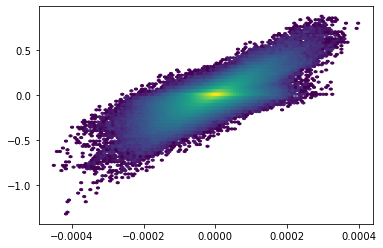

In [4]:
plt.hexbin(ds.div_ml114, ds.vertically_integrated_div_ml105_surf, norm=LogNorm())

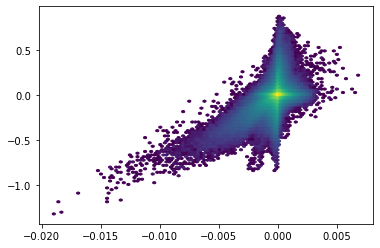

In [5]:
plt.hexbin(ds.vertically_integrated_moisture_flux_div, ds.vertically_integrated_div_ml105_surf, norm=LogNorm())

In [6]:
import pandas as pd
import seaborn as sns
from scipy.stats import linregress


In [7]:
df = ds.to_dataframe()
# Convert from divergence to convergence.
for col in df.columns:
    df[col] = -df[col]

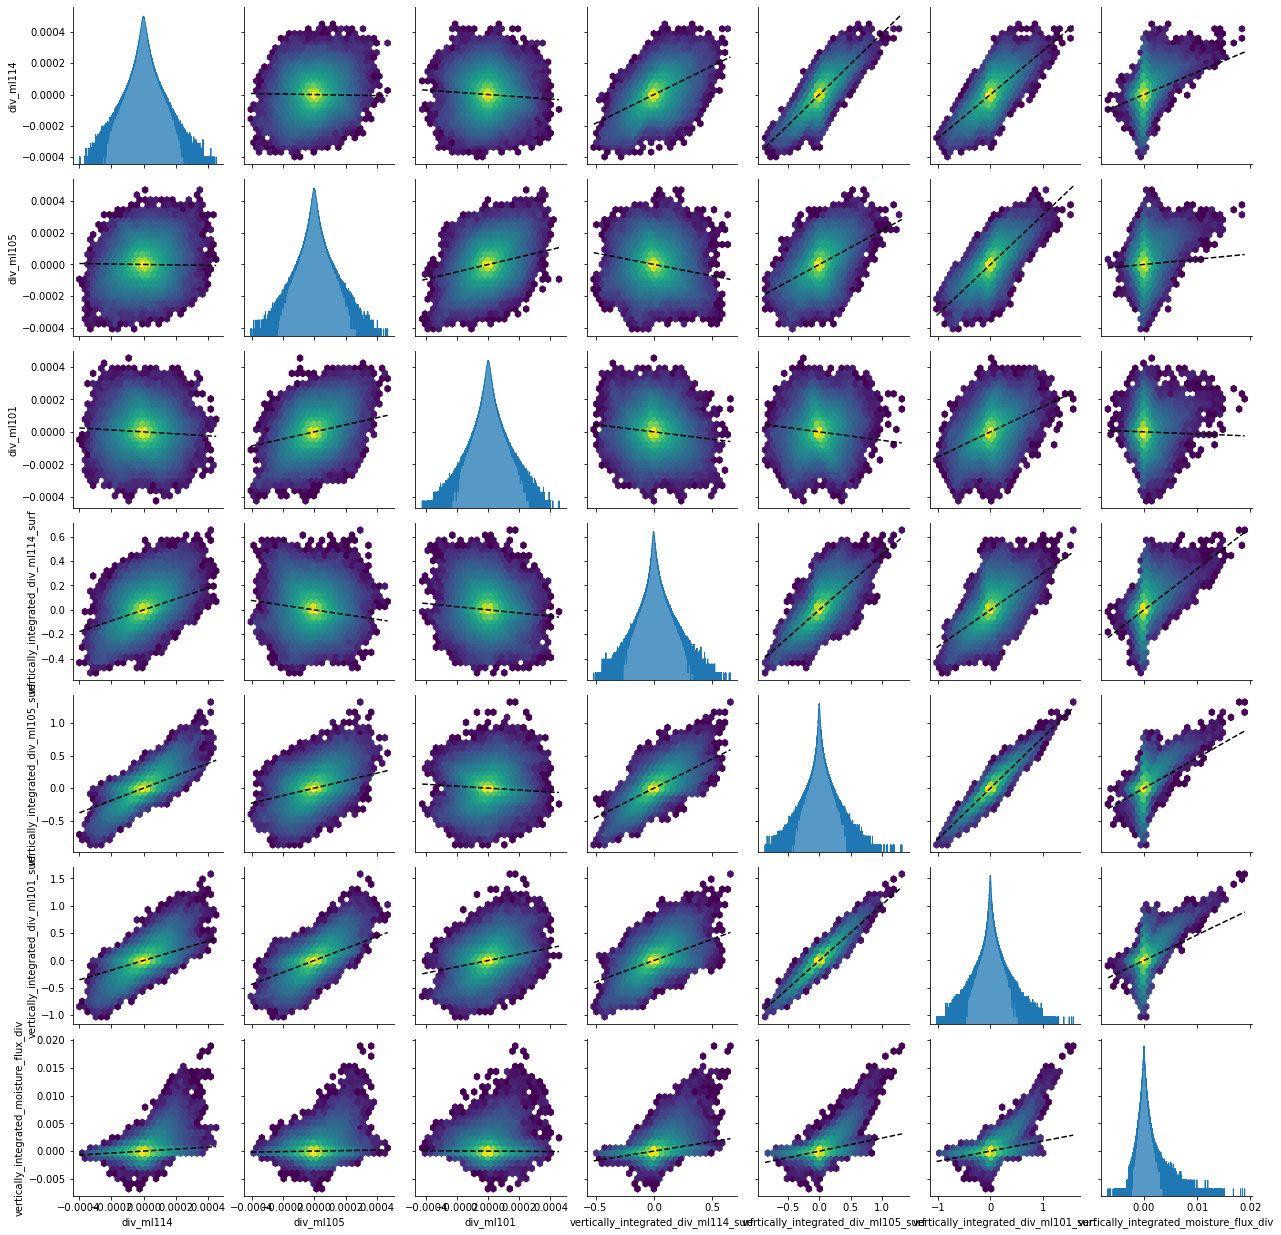

In [8]:
g = sns.PairGrid(df)
def hexbin(x, y, color, max_series=None, min_series=None, **kwargs):
    # cmap = sns.light_palette(color, as_cmap=True)
    ax = plt.gca()
    lr = linregress(x, y)
    xmin, xmax = min_series[x.name], max_series[x.name]
    ymin, ymax = min_series[y.name], max_series[y.name]
    lrx = np.array([x.min(), x.max()])
    lry = lr.slope * lrx + lr.intercept

    plt.hexbin(x, y, gridsize=25, extent=[xmin, xmax, ymin, ymax], **kwargs)
    label = f'slope: {lr.slope:.2f}\nintercept: {lr.intercept:.2f}\nr$^2$: {lr.rvalue**2:.2f}\np: {lr.pvalue:.2f}'
    plt.plot(lrx, lry, 'k--', label=label)
    #print(x.name, y.name)
    #print(label)
    ax.legend() # <- does nothing for some reason.

    
g.map_diag(sns.histplot, element='poly', log_scale=(None, True))
g.map_offdiag(hexbin, max_series=df.max(), min_series=df.min(), norm=LogNorm())

<AxesSubplot:>

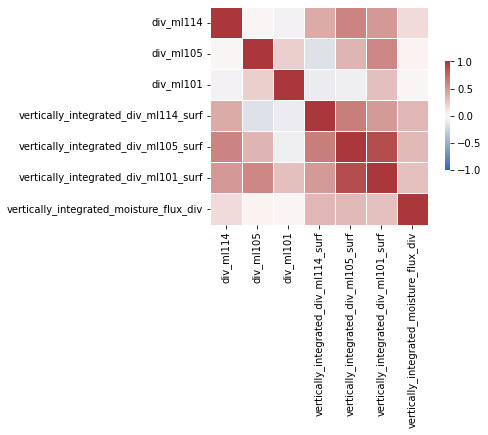

In [9]:
sns.heatmap(df.corr(), center=0, vmin=-1, vmax=1, cmap='vlag',
            square=True, linewidths=.5, cbar_kws={"shrink": .5})

In [10]:
# https://stackoverflow.com/a/50703596/54557
# df.corr().style.background_gradient(cmap='vlag')
corr = df.corr()
(corr
 .style
 .background_gradient(cmap='coolwarm', axis=None, vmin=-1, vmax=1)
 .format(precision=2))

,div_ml114,div_ml105,div_ml101,vertically_integrated_div_ml114_surf,vertically_integrated_div_ml105_surf,vertically_integrated_div_ml101_surf,vertically_integrated_moisture_flux_div
div_ml114,1.00,-0.02,-0.07,0.41,0.61,0.50,0.16
div_ml105,-0.02,1.00,0.22,-0.17,0.35,0.58,0.04
div_ml101,-0.07,0.22,1.00,-0.11,-0.09,0.30,-0.02
vertically_integrated_div_ml114_surf,0.41,-0.17,-0.11,1.00,0.64,0.49,0.34
vertically_integrated_div_ml105_surf,0.61,0.35,-0.09,0.64,1.00,0.89,0.33
vertically_integrated_div_ml101_surf,0.50,0.58,0.30,0.49,0.89,1.00,0.29
vertically_integrated_moisture_flux_div,0.16,0.04,-0.02,0.34,0.33,0.29,1.00


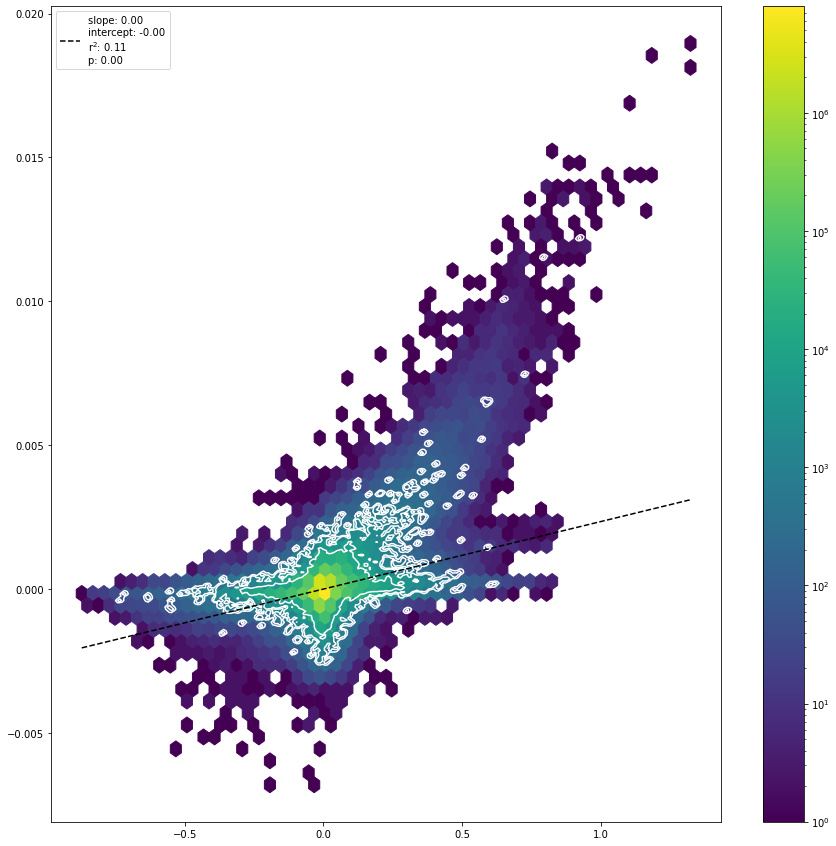

In [11]:
# cmap = sns.light_palette(color, as_cmap=True)
plt.figure(figsize=(15, 15))
x = df.vertically_integrated_div_ml105_surf
y = df.vertically_integrated_moisture_flux_div
lr = linregress(x, y)
# min_series
# xmin, xmax = min_series[x.name], max_series[x.name]
# ymin, ymax = min_series[y.name], max_series[y.name]
lrx = np.array([x.min(), x.max()])
lry = lr.slope * lrx + lr.intercept

plt.hexbin(x, y, gridsize=55, norm=LogNorm())
plt.colorbar()

idx = np.sort(np.random.choice(np.arange(len(df)), int(1e5), replace=False))
sns.kdeplot(x=x.values[idx], y=y.values[idx], levels=[0.0001, 0.001, 0.01], color='white')
label = f'slope: {lr.slope:.2f}\nintercept: {lr.intercept:.2f}\nr$^2$: {lr.rvalue**2:.2f}\np: {lr.pvalue:.2f}'
plt.plot(lrx, lry, 'k--', label=label)
#print(x.name, y.name)
#print(label)
plt.legend(loc='upper left')


In [12]:
len(df) / 1e6

16.62336